In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

FS = 12 # fontsize

In [2]:
def read_fast5(fname, single_or_multi_read, get_read_ids=False):
    'from !bsc_szakdoga/github/python_scripts/fast5_analysis.ipynb'
    from ont_fast5_api.fast5_interface import get_fast5_file
    def raw_to_current(rawdata, offset, range_, digitisation):
        return list((np.array(rawdata) + offset) * range_ / digitisation)
    
    if single_or_multi_read not in ['s', 'm']:
        raise ValueError('single_or_multi variable must be "s" or "m".')
    data = []
    read_ids = []
    with get_fast5_file(fname, mode="r") as f:
        for read in f.get_reads():
            ch=read.get_channel_info()
            data.append(raw_to_current(read.get_raw_data(), ch['offset'], ch['range'], ch['digitisation']))
            read_ids.append(read.read_id)
    if single_or_multi_read == 's':
        if get_read_ids:
            return np.array(data[0]), read_ids
        return np.array(data[0]) # single read --> dim=1
    elif single_or_multi_read == 'm':
        if get_read_ids:
            return np.array(data, dtype='object'), read_ids
        return np.array(data, dtype='object')

def find_read_id_index(string_list, search_string):
    string_array = np.array(string_list)
    index = np.where(np.char.find(string_array, search_string) != -1)[0]
    if len(index) == 1:
        return index[0]
    print(f'Error: no or more indices found; len(index)={len(index)}')
    return None

def split_raw_signal(raw_signal, move_table, stride):
    start_of_bases = (np.where(move_table == 1)[0]) * stride
    signals = [raw_signal[i:j] for i, j in zip(start_of_bases, start_of_bases[1:])]
    mean_signals = [np.mean(raw_signal[i:j]) for i, j in zip(start_of_bases, start_of_bases[1:])]
    return start_of_bases, signals, mean_signals

def replace_T_to_U(data):
    if  type(data) not in [list, np.ndarray]:
        raise TypeError(f'sam_file_names must be a list')
    for record in tqdm(data, total=len(data), desc='Replacing'):
        record['sequence'] = np.array(['U' if base == 'T' else base for base in record['sequence']])
    return np.array(data)

In [3]:
def get_data(sam):
    mv_table = re.findall(r"(mv:array\('b',.*?\))|(\S+:\S+)", sam[-1])
    mv_table = [x[0] if x[0] else x[1] for x in mv_table]
    return  {
        'read_id':sam[0], 
        'sam_flag':int(sam[1]),
        'mapped_position':int(sam[3]),
        'map_quality':int(sam[4]),
        'cigar_str':sam[5],
        'sequence':np.array(list(sam[9])),
        'move_table':np.array(mv_table[0][17:-2].split(', '), dtype='int'),
        'stride':int(mv_table[0][15]),
        'trim_offset':int(mv_table[8][3:]),
        'fast5_file_name':mv_table[6][3:]
       } 


def read_sam(sam_file_names, min_length=0, max_length=1e5, min_MAPQ=0, wrong_flags={4, 256, 272, 2048, 2064}):
    ''' read sam file '''
    ### For more files
    if  type(sam_file_names) == list:
        all_sam_data = []
        for sam_file_name in sam_file_names:
            with open(sam_file_name, 'r') as file:
                sam_files = file.read().split('\n')
                sam_files = [line for line in sam_files if not line.startswith('@')]
            one_sam_data = []
            for i in range(len(sam_files)-1):
                sam = sam_files[i].split('\t')
                data = get_data(sam)
                if (len(data['sequence']) <= max_length and
                    len(data['sequence']) >= min_length and
                    data['map_quality'] >= min_MAPQ and
                    data['sam_flag'] not in wrong_flags                     
                   ): one_sam_data.append(data)
            all_sam_data.append(np.array(one_sam_data, dtype='object'))
        return np.hstack(all_sam_data, dtype='object')
        
    ### For only one file
    elif  type(sam_file_names) == str:
        with open(sam_file_names, 'r') as file:
            sam_files = file.read().split('\n')
            sam_files = [line for line in sam_files if not line.startswith('@')]
        sam_data = []
        for i in tqdm(range(len(sam_files)-1),  total=len(sam_files)-1, desc="Loading file"):
            sam = sam_files[i].split('\t')
            data = get_data(sam)
            if (len(data['sequence']) <= max_length and
                len(data['sequence']) >= min_length and
                data['map_quality'] >= min_MAPQ and
                data['sam_flag'] not in wrong_flags                     
               ): sam_data.append(data)
        return np.array(sam_data, dtype='object')

    else:
        raise TypeError(f"'sam_file_names' must be a string or list, not {type(sam_file_names)}\n sam_file_names='{sam_file_names}'")

In [4]:
def get_feature_from_sam_data(data, feature):
    return np.array([entry[feature] for entry in data ], dtype='object')

def search_in_data(data, key, element):
    for entry in data:
        if entry[key] == element:
            return entry
    return None

---
# Reference file

In [5]:
with open("/v/volumes/nanopore/ref/p300_ID3.fasta", 'r') as file:
    p300_ID3_ref = file.read().split('\n')[1]
p300_ID3_ref = np.array(list(p300_ID3_ref))
print(f'Length of ref sequence: {len(p300_ID3_ref)}')
p300_ID3_ref

Length of ref sequence: 1164


array(['A', 'A', 'C', ..., 'C', 'A', 'G'], dtype='<U1')

---
# Thymine

In [6]:
#path_to_Thymine_fast5 = '/v/projects/nanopore/agnes/signal_visualization/data/timin0421/workspace/'
#T_fast5_files = glob(path_to_Thymine_fast5+'*.fast5')

#idx1 = 0
#fast5_file_path = path_to_Thymine_fast5 + T_sam_data[idx1]['fast5_file_name']
#fast5_signals, read_ids 

In [7]:
T_sam_data = read_sam("/v/projects/nanopore/balazs/data/thymine_0421/mapped_basecalls.sam",
                      min_length=len(p300_ID3_ref)*0.6,
                      max_length=len(p300_ID3_ref)*1.1,
                      min_MAPQ=40,
                     )

Loading file: 100%|██████████| 21418/21418 [00:14<00:00, 1451.87it/s]


In [8]:
T_sam_data.shape

(19722,)

In [9]:
read_ids = get_feature_from_sam_data(T_sam_data, 'read_id')
read_ids

array(['000b042c-f087-49bf-8ed3-e0b385e3bb5b',
       '000efc4f-8c7b-4c46-971d-aa9bb3699d14',
       '00a0ba40-383c-4f6b-b206-c37c2433b12c', ...,
       'fff89552-4aa9-48d3-b7ca-19c9e270819e',
       'fffc6b1b-16c6-414e-bcda-9d648b994ccb',
       'fffe2dbc-da7d-4fb2-857f-f271f0c90479'], dtype=object)

In [10]:
possible_positions = get_feature_from_sam_data(T_sam_data, 'mapped_position')

In [11]:
max(possible_positions)

748

In [12]:
sum(possible_positions == 0)

0

In [13]:
T_sam_data[13456] # random read from the data

{'read_id': 'afadfb5f-2bbf-4144-9ae0-d5c0a6e5474c',
 'sam_flag': 16,
 'mapped_position': 4,
 'map_quality': 60,
 'cigar_str': '15S15M3I41M1D58M1D48M1I186M1D108M1I98M1D72M1D2M2D76M1D109M1D4M2I19M1D35M1D53M2D39M3D4M1I75M1D97M52S',
 'sequence': array(['C', 'T', 'A', ..., 'A', 'T', 'G'], dtype='<U1'),
 'move_table': array([1, 1, 0, ..., 0, 0, 0]),
 'stride': 5,
 'trim_offset': 75,
 'fast5_file_name': 'aoa546_pass_235c7b69_db4f2d16_13.fast5'}

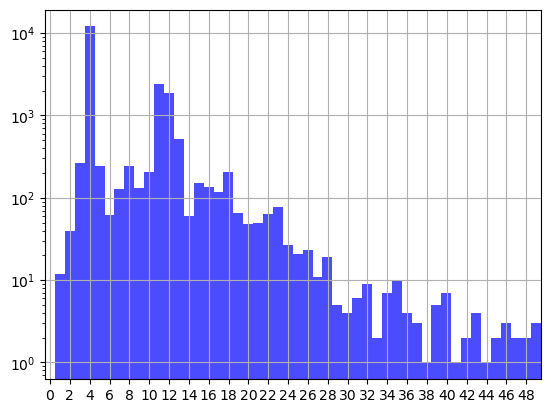

In [14]:
xlim_min=0
xlim_max=50

plt.hist(possible_positions, bins=max(possible_positions), color='blue', alpha=0.7)
plt.yscale('log')
plt.xlim(xlim_min, xlim_max)
plt.grid('dotted')
plt.xticks(np.arange(xlim_min, xlim_max, 2)+0.5, np.arange(xlim_min, xlim_max, 2))
plt.show()

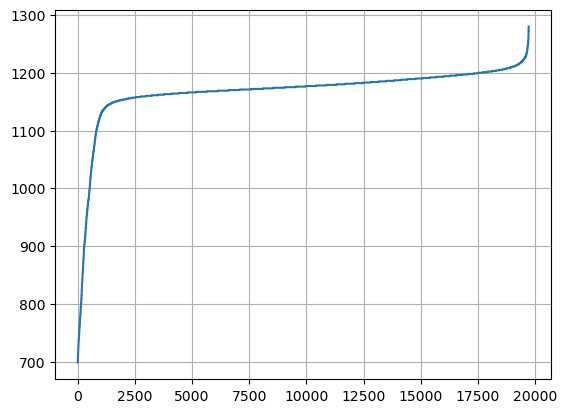

In [15]:
all_bases_T = get_feature_from_sam_data(T_sam_data, 'sequence')

all_bases_length_T = []
for item in all_bases_T:
    all_bases_length_T.append(len(item))

plt.plot(sorted(all_bases_length_T))
plt.grid()

---
# Uracil

In [16]:
U_sam_data = read_sam("/v/projects/nanopore/balazs/data/uracil_0504/mapped_basecalls.sam",
                      min_length=len(p300_ID3_ref)*0.5,
                      max_length=len(p300_ID3_ref)*1.1,
                      min_MAPQ=40,
                     )

Loading file: 100%|██████████| 257207/257207 [02:52<00:00, 1488.52it/s]


In [17]:
U_sam_data.shape

(233223,)

In [18]:
mapq = get_feature_from_sam_data(U_sam_data, 'map_quality')

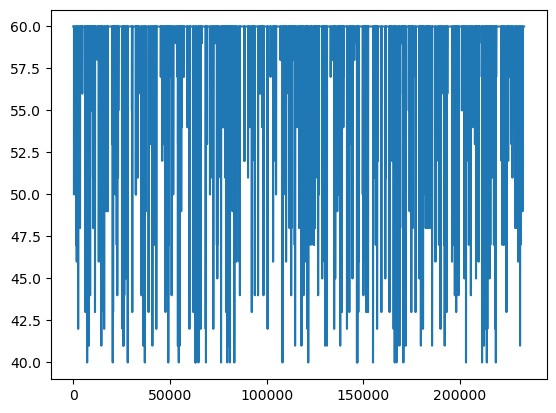

In [19]:
plt.plot(mapq)

In [20]:
path_to_Uracil_fast5 = '/v/projects/nanopore/agnes/signal_visualization/uracil0504/guppy/workspace/'
U_fast5_files = glob(path_to_Uracil_fast5+'*.fast5')

index_of_fast5 = 0
fast5_file_path = path_to_Uracil_fast5 + U_sam_data[index_of_fast5]['fast5_file_name']
fast5_signals, read_ids = read_fast5(fast5_file_path, 'm', get_read_ids=True)

In [21]:
# Replace thymine to uracil
#U_sam_data = replace_T_to_U(U_sam_data) # ~3min

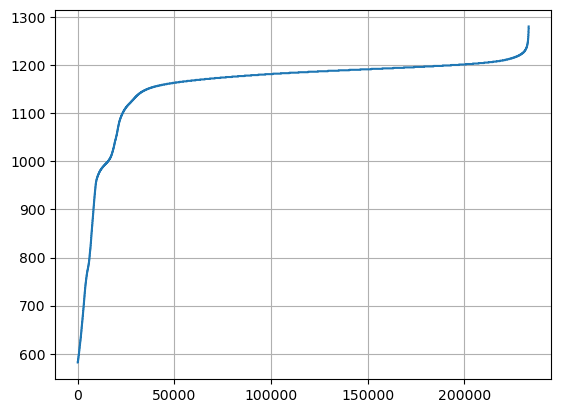

In [22]:
all_bases_U = get_feature_from_sam_data(U_sam_data, 'sequence')

all_bases_length_U = []
for item in all_bases_U:
    all_bases_length_U.append(len(item))

plt.plot(sorted(all_bases_length_U))
plt.grid()